# Clustering Analysis

## Setup

In [1]:
# Setup 

set.seed(141)

library(tidyverse)

# install.packages("cluster") # Uncomment if 'cluster' package is not installed
library(cluster) # for silhouette and other clustering tools

# install.packages("patchwork") # Uncomment if 'patchwork' package is not installed
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘patchwork’ was built under R version 4.3.3”


### 1 Visualizing Clusters and K-Means

We start with a simple 2D dataset with three clusters.

In [2]:
# 1.1 Simulate toy data with 3 clusters 
n_per_cluster <- 50

toy_df <- tibble(
  x = c(rnorm(n_per_cluster, mean = 0,  sd = 0.5),
        rnorm(n_per_cluster, mean = 3,  sd = 0.5),
        rnorm(n_per_cluster, mean = -3, sd = 0.5)),
  y = c(rnorm(n_per_cluster, mean = 0,  sd = 0.5),
        rnorm(n_per_cluster, mean = 3,  sd = 0.5),
        rnorm(n_per_cluster, mean = 3,  sd = 0.5))
)

head(toy_df)


x,y
<dbl>,<dbl>
0.25717986,0.08239196
-0.05638869,0.47107856
0.03217003,0.82696455
-0.32762240,0.05490211
0.25086210,0.19391889
-0.41762474,0.04046896


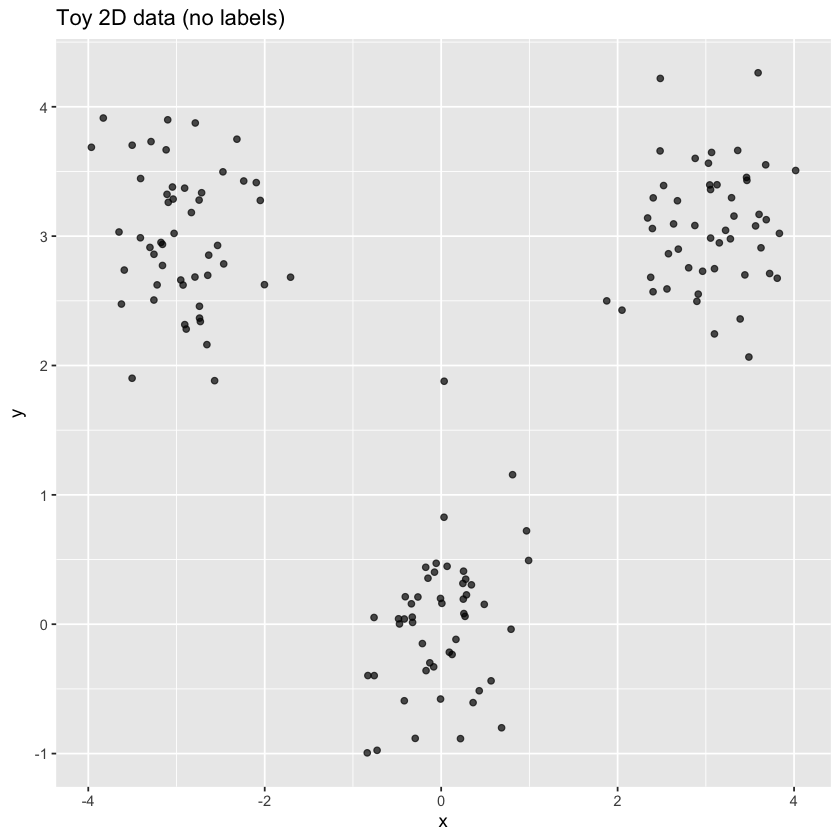

In [3]:
# Plot unlabeled data

ggplot(toy_df, aes(x = x, y = y)) +
  geom_point(alpha = 0.7) +
  labs(title = "Toy 2D data (no labels)", x = "x", y = "y")


### 1.1 Apply K-means with $K = 3$


In [4]:
# K-means with K = 3 --------------------------------------------------

k3_fit <- kmeans(toy_df, centers = 3, nstart = 20)
k3_fit


K-means clustering with 3 clusters of sizes 50, 50, 50

Cluster means:
             x          y
1  0.005884982 0.01265289
2  3.047446394 3.06661887
3 -2.937414069 2.99526275

Clustering vector:
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3

Within cluster sum of squares by cluster:
[1] 24.37625 22.91473 24.60094
 (between_SS / total_SS =  94.3 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

In [5]:
# Inspect centers and within-cluster sums of squares
k3_fit$centers
k3_fit$tot.withinss
k3_fit$withinss


,x,y
1,0.005884982,0.01265289
2,3.047446394,3.06661887
3,-2.937414069,2.99526275


[1] 71.89192

[1] 24.37625 22.91473 24.60094

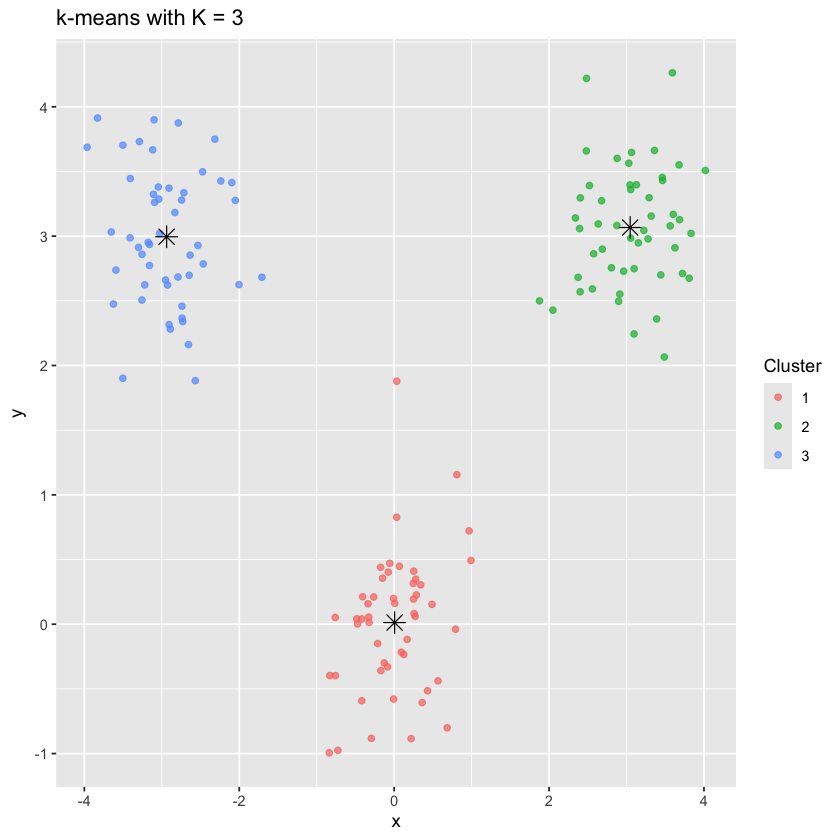

In [6]:
# Visualization of k-means clustering results
toy_df_k3 <- toy_df |>
  mutate(cluster = factor(k3_fit$cluster))

ggplot(toy_df_k3, aes(x = x, y = y, color = cluster)) +
  geom_point(alpha = 0.7) +
  geom_point(data = as_tibble(k3_fit$centers),
             aes(x = x, y = y),
             size = 4, shape = 8,
             inherit.aes = FALSE) +
  labs(title = "k-means with K = 3", color = "Cluster")


### 1.2 Trying different K values

Try $K = 2$ and $K = 4$ to illustrate under- and over-clustering.

In [7]:
# K = 2 and K = 4 
k2_fit <- kmeans(toy_df, centers = 2, nstart = 20)
k4_fit <- kmeans(toy_df, centers = 4, nstart = 20)

toy_df_k2 <- toy_df |>
  mutate(cluster = factor(k2_fit$cluster))
toy_df_k4 <- toy_df |>
  mutate(cluster = factor(k4_fit$cluster))


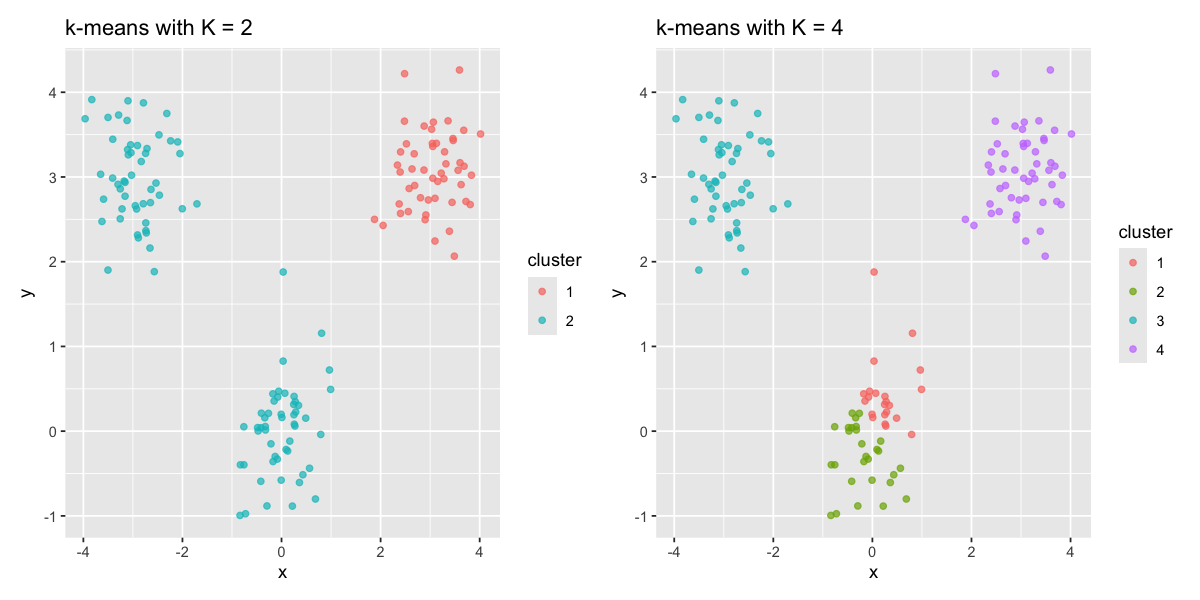

In [9]:
options(repr.plot.width = 10, repr.plot.height = 5)

p1 <- ggplot(toy_df_k2, aes(x = x, y = y, color = cluster)) +
  geom_point(alpha = 0.7) +
  labs(title = "k-means with K = 2")

p2 <- ggplot(toy_df_k4, aes(x = x, y = y, color = cluster)) +
  geom_point(alpha = 0.7) +
  labs(title = "k-means with K = 4")

p1 | p2

### 2.1 K-Means on  `iris`

We now run k-means on the classic `iris` dataset.

In [10]:
# Inspect iris data ---------------------------------------------------

iris |>
  as_tibble() |>
  head()


Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


In [11]:
# Use only numeric columns and scale them -----------------------------

iris_numeric <- iris |>
  as_tibble() |>
  select(-Species)

iris_scaled <- iris_numeric |>
  scale() |>
  as_tibble()

head(iris_scaled)


Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
<dbl>,<dbl>,<dbl>,<dbl>
-0.8976739,1.01560199,-1.335752,-1.311052
-1.1392005,-0.13153881,-1.335752,-1.311052
-1.3807271,0.32731751,-1.392399,-1.311052
-1.5014904,0.09788935,-1.279104,-1.311052
-1.0184372,1.24503015,-1.335752,-1.311052
-0.5353840,1.93331463,-1.165809,-1.048667


### 2.2 K-means with $K = 3$


In [12]:
# K-means on scaled iris with K = 3 ----------------------------------

set.seed(141)
iris_k3 <- kmeans(iris_scaled, centers = 3, nstart = 20)
iris_k3


K-means clustering with 3 clusters of sizes 53, 47, 50

Cluster means:
  Sepal.Length Sepal.Width Petal.Length Petal.Width
1  -0.05005221 -0.88042696    0.3465767   0.2805873
2   1.13217737  0.08812645    0.9928284   1.0141287
3  -1.01119138  0.85041372   -1.3006301  -1.2507035

Clustering vector:
  [1] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [38] 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1
 [75] 1 2 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
[112] 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 2 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 2 1 2
[149] 2 1

Within cluster sum of squares by cluster:
[1] 44.08754 47.45019 47.35062
 (between_SS / total_SS =  76.7 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

In [13]:
iris_clustered <- iris_scaled |>
  mutate(cluster = factor(iris_k3$cluster),
         Species = iris$Species)

head(iris_clustered)


Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,cluster,Species
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
-0.8976739,1.01560199,-1.335752,-1.311052,3,setosa
-1.1392005,-0.13153881,-1.335752,-1.311052,3,setosa
-1.3807271,0.32731751,-1.392399,-1.311052,3,setosa
-1.5014904,0.09788935,-1.279104,-1.311052,3,setosa
-1.0184372,1.24503015,-1.335752,-1.311052,3,setosa
-0.5353840,1.93331463,-1.165809,-1.048667,3,setosa


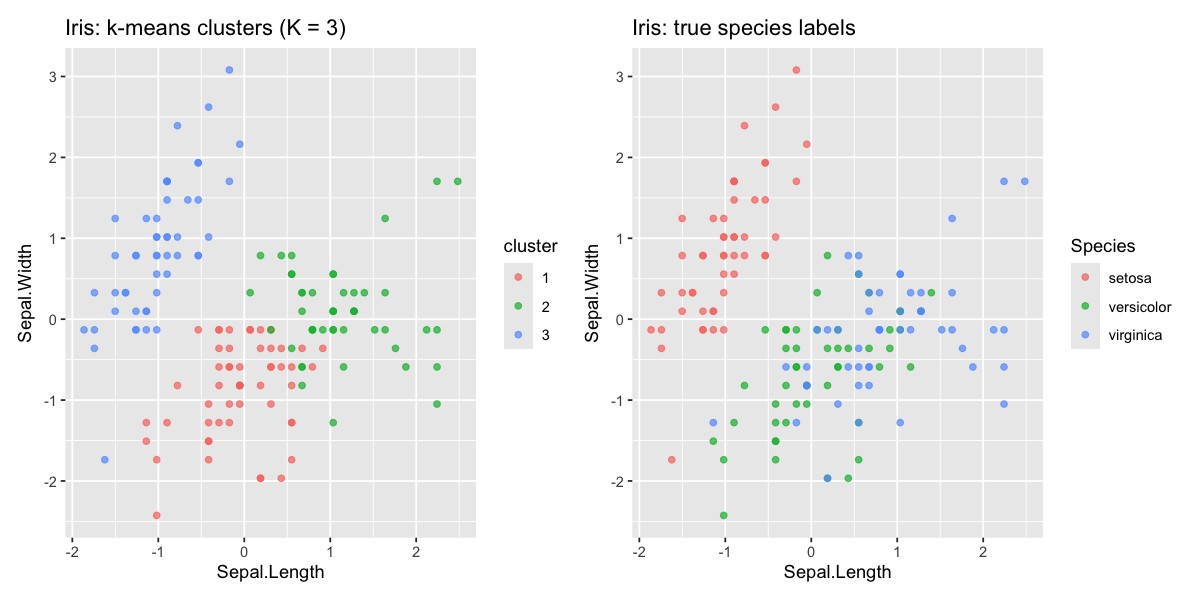

In [15]:
# Plot by cluster assignments ----------------------------------------

p1<- ggplot(iris_clustered,
       aes(x = Sepal.Length, y = Sepal.Width, color = cluster)) +
  geom_point(alpha = 0.7) +
  labs(title = "Iris: k-means clusters (K = 3)")

# Plot by true species -----------------------------------------------

p2<- ggplot(iris_clustered,
       aes(x = Sepal.Length, y = Sepal.Width, color = Species)) +
  geom_point(alpha = 0.7) +
  labs(title = "Iris: true species labels")

p1 | p2

In [16]:
# Cluster vs species contingency table -------------------------------

table(cluster = iris_clustered$cluster,
      species = iris_clustered$Species)


       species
cluster setosa versicolor virginica
      1      0         39        14
      2      0         11        36
      3     50          0         0

### 2.3 Silhouette as a cluster quality measure 

In [17]:
# Silhouette for K = 3 ------------------------------------------------

iris_dist <- dist(iris_scaled)
iris_sil  <- silhouette(iris_k3$cluster, iris_dist)

summary(iris_sil)


Silhouette of 150 units in 3 clusters from silhouette.default(x = iris_k3$cluster, dist = iris_dist) :
 Cluster sizes and average silhouette widths:
       53        47        50 
0.3933772 0.3473922 0.6363162 
Individual silhouette widths:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.02489  0.35914  0.47113  0.45995  0.58883  0.73419 

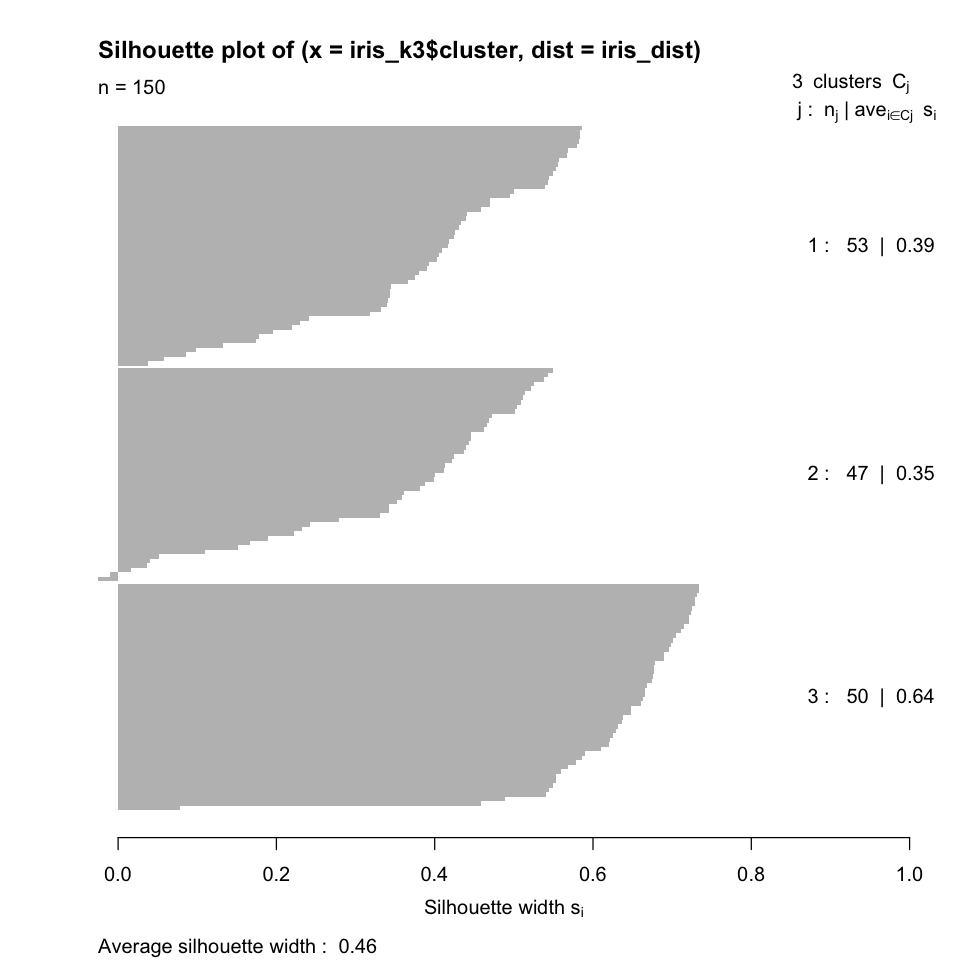

In [20]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot(iris_sil, border = NA)


### 3 Hierarchical Clustering on `iris`

We now perform hierarchical clustering using complete linkage.

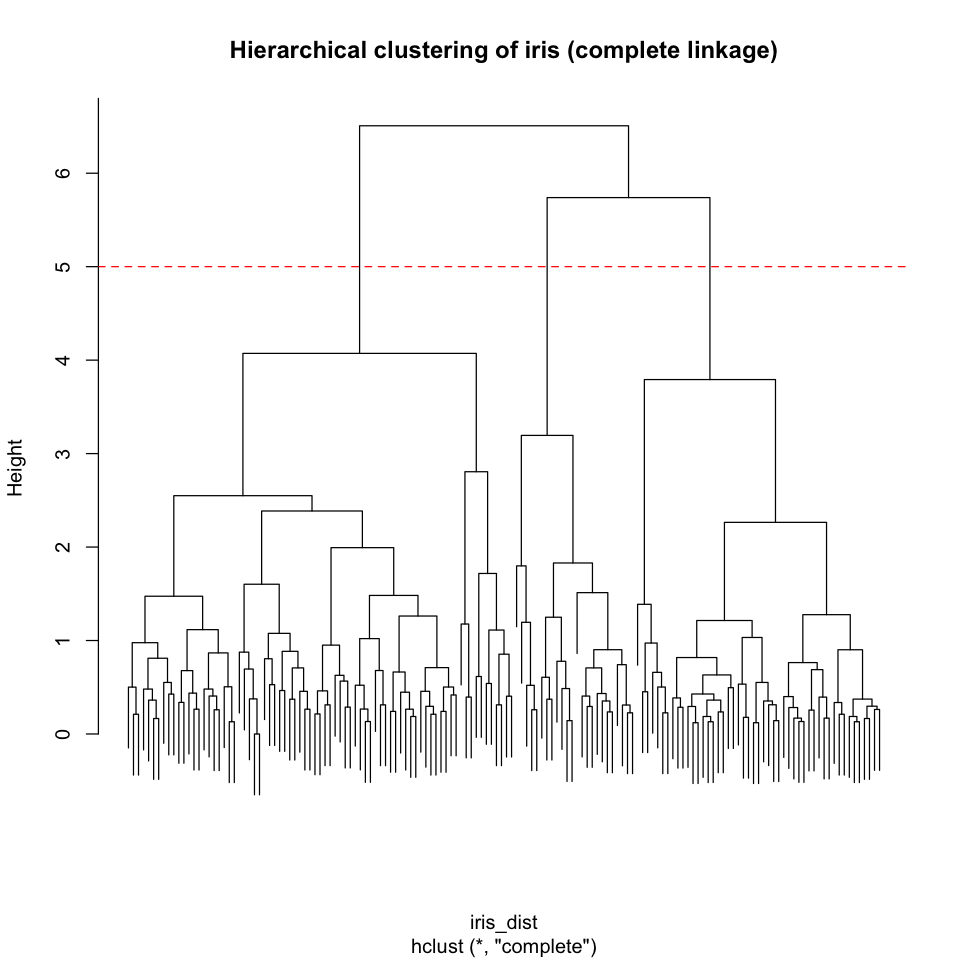

In [21]:
# Hierarchical clustering --------------------------------------------

iris_dist <- dist(iris_scaled, method = "euclidean")
iris_hc   <- hclust(iris_dist, method = "complete")

plot(iris_hc, labels = FALSE,
     main = "Hierarchical clustering of iris (complete linkage)")
abline(h = 5, col = "red", lty = 2)  # example cut height


In [22]:
# Cut tree into 3 clusters -------------------------------------------

hc_clusters <- cutree(iris_hc, k = 3)

tab_hc <- table(hc_cluster = hc_clusters, species = iris$Species)
tab_hc


          species
hc_cluster setosa versicolor virginica
         1     49          0         0
         2      1         21         2
         3      0         29        48

# Exercise

### Exercise 1 Exploration of `USArrests`

1. Convert `USArrests` to a tibble with a `State` column.
2. Compute basic summaries.
3. Make at least one scatterplot of two variables.


In [ ]:
# 1

# TODO: explore USArrests
# arrests <- USArrests |>
#   as_tibble(rownames = "State")
# head(arrests)
# summaries <- arrests |>
#   summarize(across(-State, list(mean = mean, sd = sd)))
# summaries
# ggplot(arrests, aes(x = UrbanPop, y = Assault)) +
#   geom_point()


### Exercise 2 Scaling 

Drop the `State` variable, scale numeric variables, and check that columns have mean 0 and standard deviation 1.

In [3]:
# 2

# TODO: create arrests_numeric and arrests_scaled ---------------------

# arrests_numeric <- arrests |>
#   select(-State)
# arrests_scaled <- arrests_numeric |>
#   scale() |>
#   as_tibble()
# summary(arrests_scaled)


### Exercise 3 Choosing K with an Elbow Plot

1. For $K = 1,\dots,8$, run k-means with `nstart = 20` on `arrests_scaled`.
2. Collect `tot.withinss`.
3. Plot `tot.withinss` vs K.
4. Discuss reasonable K choices.


In [ ]:
# 3

# TODO: create an elbow plot -----------------------------------------

# set.seed(141)
# k_values <- 1:8
# k_results <- tibble(
#   K = k_values,
#   tot_withinss = purrr::map_dbl(k_values, ~{
#     k_fit <- kmeans(arrests_scaled, centers = .x, nstart = 20)
#     k_fit$tot.withinss
#   })
# )
# ggplot(k_results, aes(x = K, y = tot_withinss)) +
#   geom_line() + geom_point()


### Exercise 4 K-Means with $K$ of your choice

- Choose a K (e.g., 3) based on the elbow plot.
- Run k-means, attach cluster labels, and visualize clusters.


In [ ]:
# 4

# TODO: pick a K and run kmeans() ------------------------------------

# set.seed(141)
# k_chosen <- 3  # or your choice
# k_fit_arrests <- kmeans(arrests_scaled, centers = k_chosen, nstart = 20)
# arrests_k <- arrests |>
#   mutate(cluster = factor(k_fit_arrests$cluster))
# ggplot(arrests_k, aes(x = Murder, y = Assault, color = cluster)) +
#   geom_point()


### Exercise 5 Relating Clusters to Geography

- Add a `Region` column using `state.region`.
- Make a table of `cluster` by `Region`.


In [ ]:
# 5

# TODO: add Region and count -----------------------------------------

# arrests_k_region <- arrests_k |>
#   mutate(Region = state.region)
# arrests_k_region |>
#   count(Region, cluster)


### Exercise 6 Hierarchical Clustering on `USArrests`

1. Compute a distance matrix on `arrests_scaled`.
2. Run hierarchical clustering with complete linkage.
3. Plot dendrogram and cut tree at K = 3.
4. Compare to k-means clusters.


In [ ]:
# 6

# TODO: hierarchical clustering --------------------------------------

# arrests_dist <- dist(arrests_scaled, method = "euclidean")
# arrests_hc   <- hclust(arrests_dist, method = "complete")
# plot(arrests_hc, labels = arrests$State)
# hc_clusters <- cutree(arrests_hc, k = 3)
# table(hc_cluster = hc_clusters, kmeans_cluster = arrests_k$cluster)
